# Relationship between Critical Temperature and other features
- It follows an evaluation of the best results, looking for:
    - the *coefficients* of the Linear Regression model
    - the *feature importance* based on *mean decrease in impurity*, of Random Forest and XGBoost models
    - the *feature importance* based on *feature permutation*, of Random Forest and XGBoost models
    https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from utils.Combinations import Combination
from utils.Search import grid_search

from utils.Custom_Steps import HighCorrFeaturesRemover
from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

In [2]:
plt.style.use("seaborn-v0_8")

DATA_FOLDER = "data/"
OUTPUT_FOLDER = "outputs/"

RANDOM_STATE = 42

---
---
## Data Load
(same as in training phase)

In [3]:
df = pd.concat(
    [
        pd.read_csv(DATA_FOLDER + "formula_train.csv").drop(columns=["critical_temp"]),
        pd.read_csv(DATA_FOLDER + "train.csv"),
    ],
    axis=1,
)

# Remove "material" feature (as explained in '0_DataExploration.ipynb')
df = df.drop(columns="material")

print("Shapes of Properties+Formula df: ", df.shape)

Shapes of Properties+Formula df:  (17010, 168)


---
---
## Split
(same as in training phase)

In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

X_train = train.drop(columns=["critical_temp"])
y_train = train[["critical_temp"]]

X_test = test.drop(columns=["critical_temp"])
y_test = test[["critical_temp"]]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13608, 167), (3402, 167), (13608, 1), (3402, 1))

---
---
## Linear Regression
- Testing the best configuration

In [5]:
estimator_tag = "linear_regression"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "minmax + linear_regression",
            Pipeline([("minmax", preprocessing.MinMaxScaler()), ("linear_regression", LinearRegression())]),
            {},
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

# Take the coefficients of the model
coefs_lr = [
    (feature, coef) for feature, coef in zip(model.named_steps["minmax"].get_feature_names_out(), model[-1].coef_)
]
coefs_lr.sort(key=lambda x: abs(x[1]), reverse=True)


Combination 1/1  |  minmax + linear_regression


  ==> R2: 0.7538253028800117	MSE: 280.10712800562004


---
## Random Forest
- Testing the best configuration

In [6]:
estimator_tag = "random_forest"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "high_corr_features_remover + lmax + minmax + random_forest",
            Pipeline(
                [
                    ("high_corr_features_remover", HighCorrFeaturesRemover()),
                    ("lmax", preprocessing.Normalizer(norm="max")),
                    ("minmax", preprocessing.MinMaxScaler()),
                    ("random_forest", RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "high_corr_features_remover__corr_threshold": [0.99],
                "random_forest__max_samples": [0.66],
                "random_forest__criterion": ["squared_error"],
                "random_forest__n_estimators": [200],
                "random_forest__max_depth": [25],
                "random_forest__max_features": [0.6],
                "random_forest__ccp_alpha": [0],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

# Take the Mean Decrease in Impurity from the model
impurity_decrease_rf = [
    (feature, coef)
    for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, model[-1].feature_importances_)
]
impurity_decrease_rf.sort(key=lambda x: x[1], reverse=True)


# Calculate the feature Permutation for the model
features_permutation_rf = permutation_importance(
    model[-1],
    model[:-1].transform(X_test),
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
).importances_mean

features_permutation_rf = [
    (feature, coef) for feature, coef in zip(model.named_steps["lmax"].feature_names_in_, features_permutation_rf)
]
features_permutation_rf.sort(key=lambda x: x[1], reverse=True)


Combination 1/1  |  high_corr_features_remover + lmax + minmax + random_forest


KeyboardInterrupt: 

---
## XGBoost
- Testing the best configuration

In [ ]:
estimator_tag = "xg_boost"
model = grid_search(
    OUTPUT_FOLDER,
    X_train,
    y_train,
    X_test,
    y_test,
    [
        Combination(
            "xg_boost",
            Pipeline(
                [
                    ("xg_boost", XGBRegressor(n_jobs=-1, random_state=RANDOM_STATE)),
                ]
            ),
            {
                "xg_boost__n_estimators": [450],
                "xg_boost__learning_rate": [0.15],
                "xg_boost__max_depth": [6],
                "xg_boost__min_child_weight": [3],
                "xg_boost__gamma": [0.5],
                "xg_boost__subsample": [1.0],
                "xg_boost__colsample_bytree": [1.0],
                "xg_boost__reg_lambda": [1.0],
                "xg_boost__reg_alpha": [0.1],
                "xg_boost__tree_method": ["auto"],
            },
        )
    ],
    estimator_tag=estimator_tag,
    save_results=False,
)

# Take the Mean Decrease in Impurity from the model
impurity_decrease_xgb = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, model[-1].feature_importances_)
]
impurity_decrease_xgb.sort(key=lambda x: abs(x[1]), reverse=True)

# Calculate the feature Permutation for the model
features_permutation_xgb = permutation_importance(
    model[-1],
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
).importances_mean

features_permutation_xgb = [
    (feature, coef) for feature, coef in zip(model[-1].get_booster().feature_names, features_permutation_xgb)
]
features_permutation_xgb.sort(key=lambda x: x[1], reverse=True)


Combination 1/1  |  xg_boost
  ==> R2: 0.9313694294022581	MSE: 78.09052777731449


---
---
## Heatmaps
- Plotting a heatmap of the extracted parameters for each model

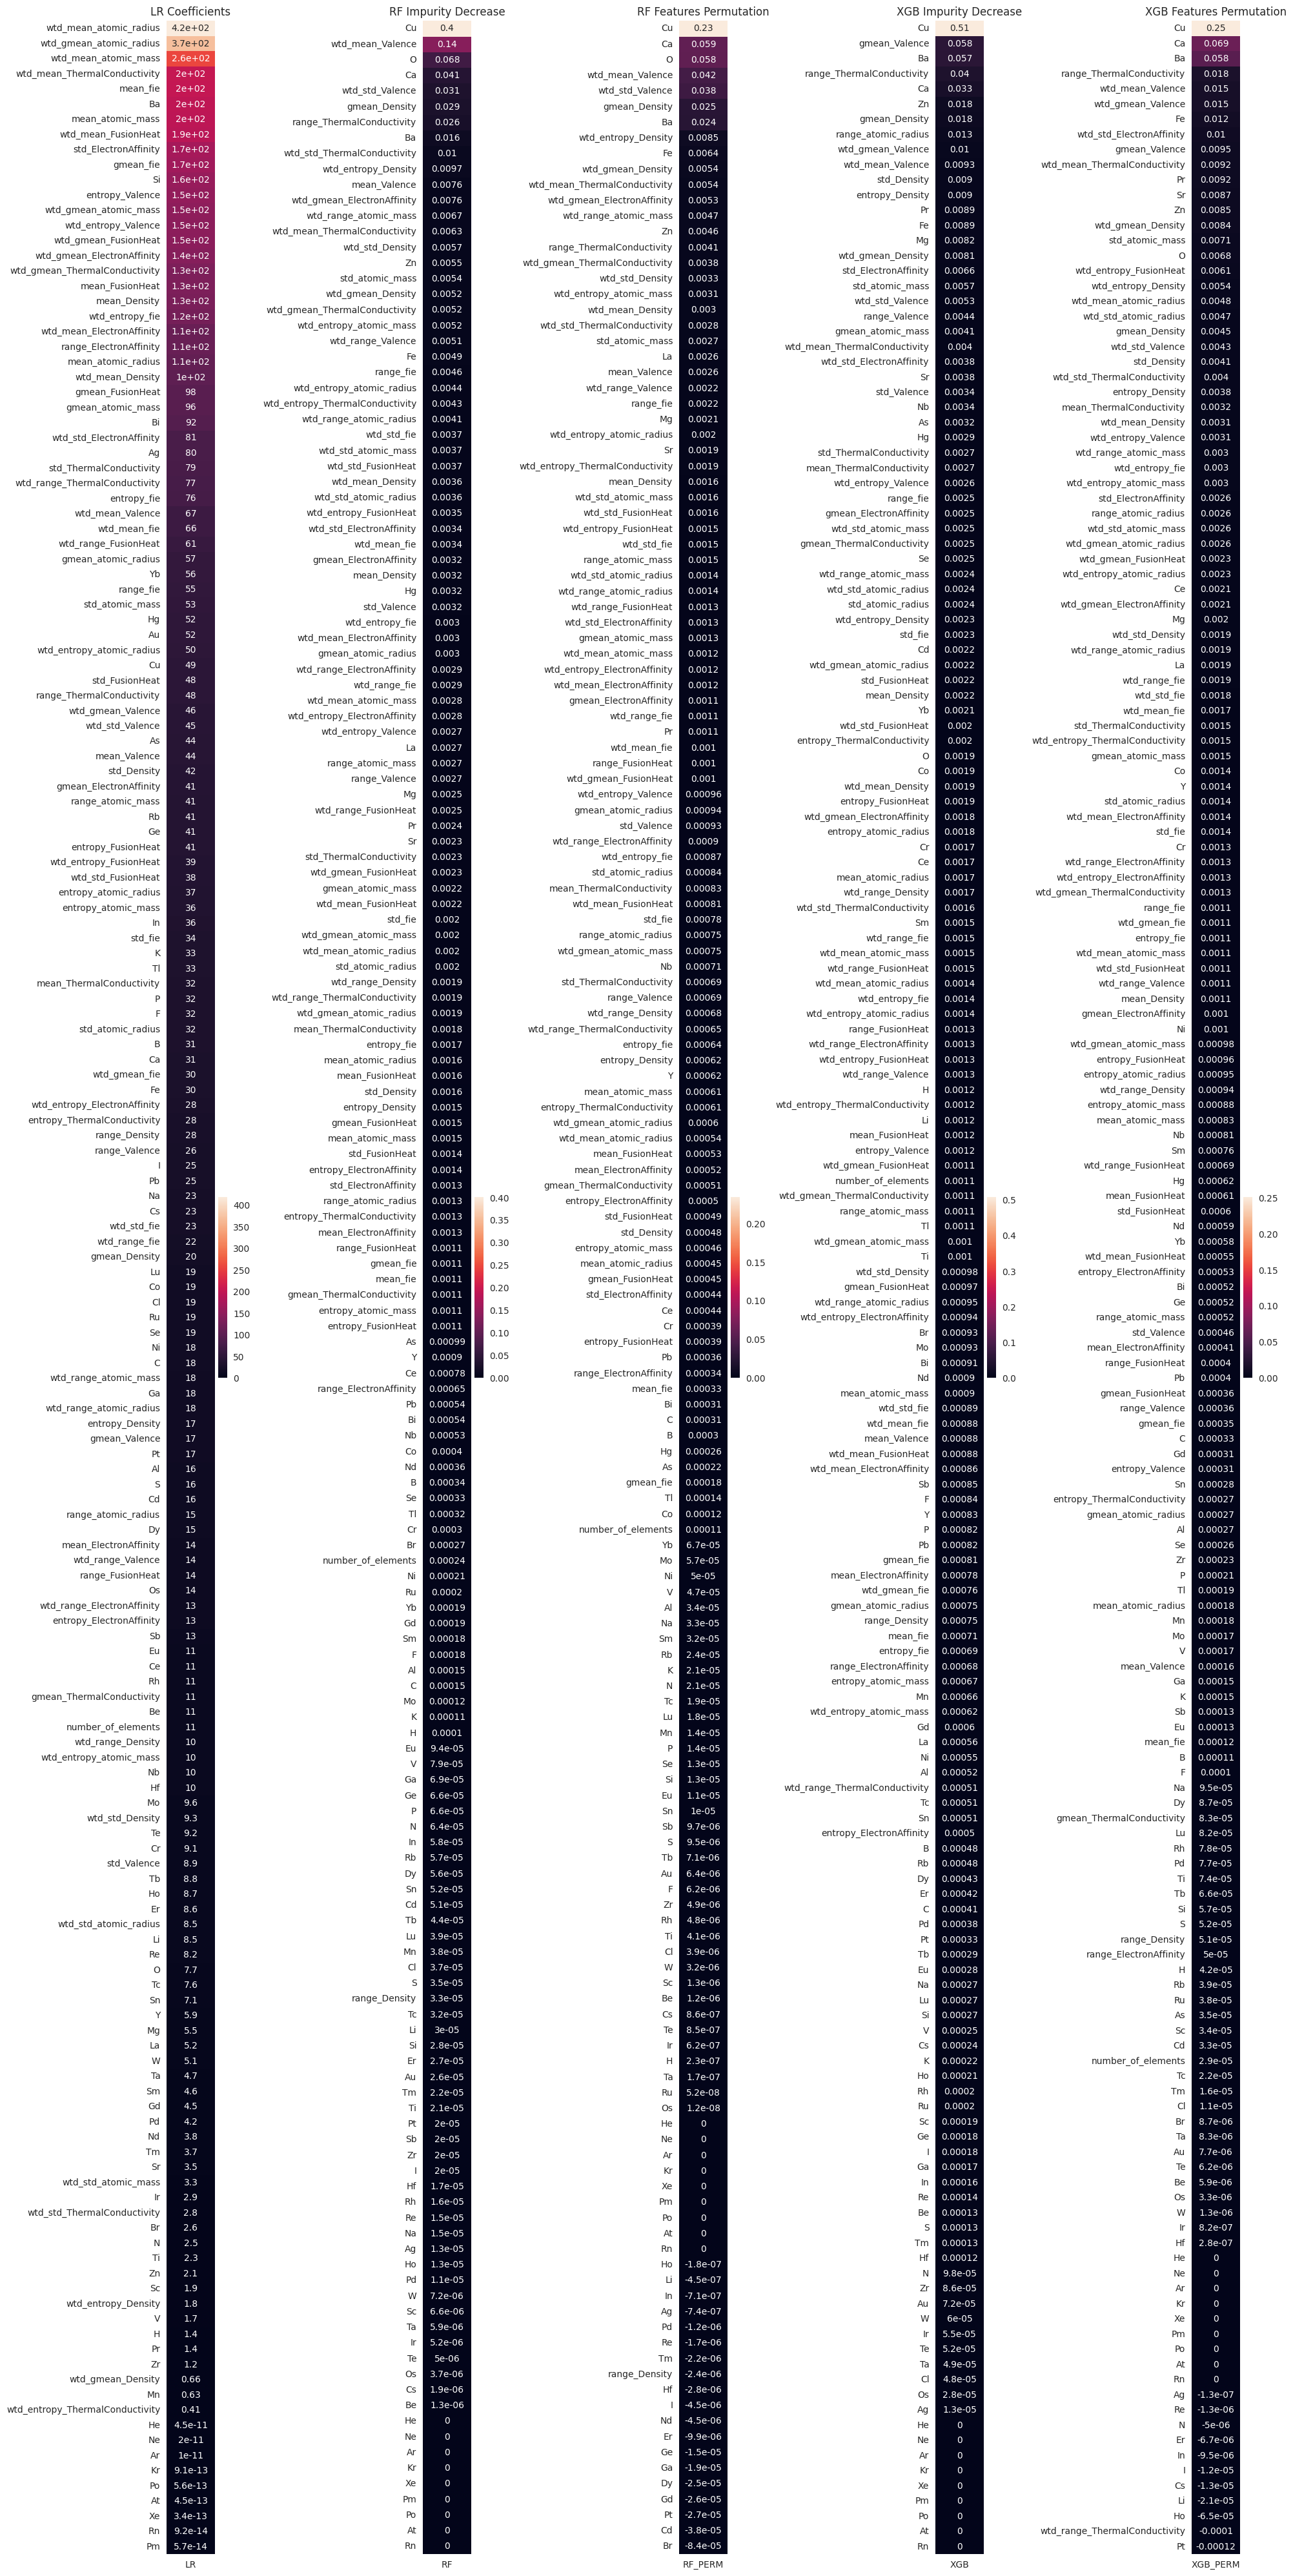

In [ ]:
fig = plt.figure(figsize=(20, 40))
gs = gridspec.GridSpec(1, 5)

# Coefficients of Linear Regression
ax = plt.subplot(gs[0])
df = pd.DataFrame(index=[x[0] for x in coefs_lr])
df["LR"] = [abs(x[1]) for x in coefs_lr]
sns.heatmap(df[["LR"]], annot=True, ax=ax)
ax.set_title("LR Coefficients")

# Impurity Decrease of Random Forest
ax = plt.subplot(gs[1])
df = pd.DataFrame(index=[x[0] for x in impurity_decrease_rf])
df["RF"] = [x[1] for x in impurity_decrease_rf]
sns.heatmap(df[["RF"]], annot=True, ax=ax)
ax.set_title("RF Impurity Decrease")

# Features Permutation of Random Forest
ax = plt.subplot(gs[2])
df = pd.DataFrame(index=[x[0] for x in features_permutation_rf])
df["RF_PERM"] = [x[1] for x in features_permutation_rf]
sns.heatmap(df[["RF_PERM"]], annot=True, ax=ax)
ax.set_title("RF Features Permutation")

# Impurity Decrease of XGBoost
ax = plt.subplot(gs[3])
df = pd.DataFrame(index=[x[0] for x in impurity_decrease_xgb])
df["XGB"] = [x[1] for x in impurity_decrease_xgb]
sns.heatmap(df[["XGB"]], annot=True, ax=ax)
ax.set_title("XGB Impurity Decrease")

# Features Permutation of XGBoost
ax = plt.subplot(gs[4])
df = pd.DataFrame(index=[x[0] for x in features_permutation_xgb])
df["XGB_PERM"] = [x[1] for x in features_permutation_xgb]
sns.heatmap(df[["XGB_PERM"]], annot=True, ax=ax)
ax.set_title("XGB Features Permutation")


plt.tight_layout()
plt.show()